# Hospital costs
&ensp; Name:        hospital_case.ipynb <br>
&ensp; Description: To calculate a hospital's allowed cost, make a model for predicting the average cost per patient <br>


# Import Packages

In [1]:
!pip install xgboost

import numpy as np 
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split #single train/test split
import statsmodels.api as sm # statsmodel over sklearn for model summary function
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
os.chdir(r'C:\Users\M-P\Downloads')

## Load Data

In [3]:
# Read data file
data = pd.read_excel("C:\Users\M-P\Downloads\210920-Hospital case Data.xlsx" )

data.head()

,CLIENT_NO,CITY,HOSPITAL,GENDER,AGE_GROUP,AGE,SOCIAL_CLASS,DIAGNOSIS_GROUP,COST
0,28757752.0,Tilburg,X,F,60-69,60,D,none,2221.60
1,78830513.0,Zwolle,AE,F,50-59,57,B2,none,1842.71
2,40897692.0,Woerden,AU,M,01-09,4,D,stomach/bowels,2187.21
3,88301740.0,Den Helder,U,F,80+,100,D,none,2261.55
4,94046728.0,Hoorn,AH,F,70-79,73,A,none,1897.32


## Inspection and descriptives of data
&ensp; - Finding relevant variables, sorting categorical values <br>


In [4]:
#variables in the data frame
list(data.columns)

['CLIENT_NO',
 'CITY',
 'HOSPITAL',
 'GENDER',
 'AGE_GROUP',
 'AGE',
 'SOCIAL_CLASS',
 'DIAGNOSIS_GROUP',
 'COST']

In [5]:
# Summarize the data frame:
display(data.describe())

# Summary of non-categorical variables
list_cat_vars = [col for col in data.select_dtypes(include=['object']).columns]
print("The following columns are catagorical variables:",list_cat_vars)

,CLIENT_NO,AGE,COST
count,2.425970e+05,242597.000000,242597.000000
mean,5.002814e+07,48.663796,2113.328175
std,2.886363e+07,26.597467,528.457891
min,3.460000e+02,0.000000,1202.250000
25%,2.508236e+07,27.000000,1809.620000
50%,4.998634e+07,52.000000,2027.920000
75%,7.500485e+07,69.000000,2293.440000
max,9.999999e+07,101.000000,7716.720000


The following columns are catagorical variables: ['CITY', 'HOSPITAL', 'GENDER', 'AGE_GROUP', 'SOCIAL_CLASS', 'DIAGNOSIS_GROUP']


In [7]:
# Plot the number of observations per category
def plotCategoryCount(data, var, width = 15, heigth = 5):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, heigth) 
    category_counts = data[var].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(category_counts.index, category_counts.values, alpha=0.9)
    plt.title('Frequency Distribution of ' + var)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(var, fontsize=12)
    plt.show()

C:\Users\M-P\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


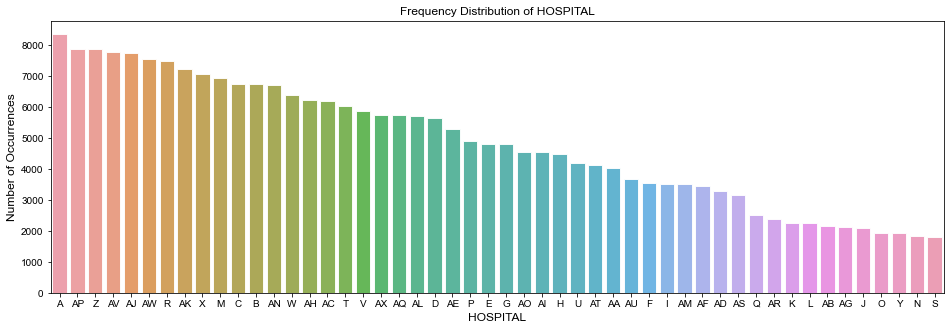

None

In [8]:
#Distribution of observations over categories
display(plotCategoryCount(data, 'HOSPITAL', width = 16))

The following columns contain missing values: []


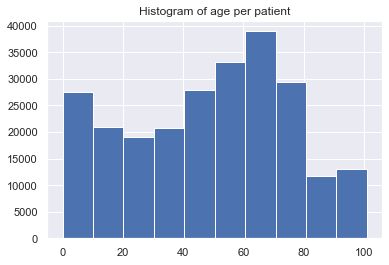

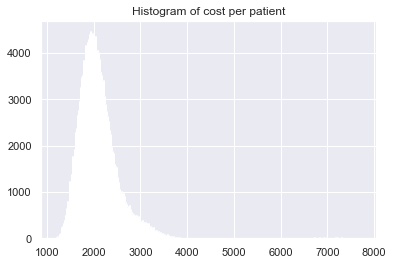

In [9]:
# Check for columns with missing values
list_col_with_missing = [col for col in data.columns if data[col].isnull().any()]
print("The following columns contain missing values:",list_col_with_missing)

# Get histograms of continuous data
_ = plt.hist(data["AGE"])
plt.title('Histogram of age per patient')
plt.show()

_ = plt.hist(data["COST"], bins='auto')
plt.title('Histogram of cost per patient')
plt.show()

## Split data into target and predictor variables


In [10]:
# Split data into X (all explanatory variables) and y (variable to be predicted by X, i.e. the cost)
X = data.drop(["COST"], axis = 1) 
y = data["COST"]

print(data.columns)

# Variables to include in model, split into continuous and categorical
continuous_vars_to_incl = [] # Age is already included as categorical variable
categorical_vars_to_incl = ['GENDER', 'AGE_GROUP', 'SOCIAL_CLASS', 'DIAGNOSIS_GROUP']

# Dummify all categorical variables
dummies = pd.get_dummies(X[categorical_vars_to_incl], drop_first = True)
X = pd.concat([X[continuous_vars_to_incl], dummies], axis=1)

Index(['CLIENT_NO', 'CITY', 'HOSPITAL', 'GENDER', 'AGE_GROUP', 'AGE',
       'SOCIAL_CLASS', 'DIAGNOSIS_GROUP', 'COST'],
      dtype='object')


## Fit Model
* Fit linear model (statistics) <br>
* Fit XGBoost Model (machine learning)  <br>

### Linear Model

In [11]:
# For Linear Regression (OLS) we first need to add a constant
X_OLS = sm.add_constant(X)

# Fit a model
linear_model = sm.OLS(endog=y, exog=X_OLS).fit()

# Calculate fitted values
y_pred_linear = linear_model.predict(X_OLS) 

# Show the model's coefficients and other information
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   COST   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 4.730e+04
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:26:01   Log-Likelihood:            -1.6427e+06
No. Observations:              242597   AIC:                         3.286e+06
Df Residuals:                  242569   BIC:                         3.286e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            2187.6022      3.889    562.495      0.000    2179.980    2195.225
GENDER_M                          127.1738      0.859    148.125      0.000     125.491     128.857
AGE_GROUP_01-09                  -402.3383      3.165   -127.125      0.000    -408.541    -396.135
AGE_GROUP_10-19                  -385.6426      3.137   -122.952      0.000    -391.790    -379.495
AGE_GROUP_20-29                  -248.5580      3.178    -78.217      0.000    -254.786    -242.330
AGE_GROUP_30-39                  -200.0708      3.157    -63.371      0.000    -206.259    -193.883
AGE_GROUP_40-49                  -195.3727      3.060    -63.842      0.000    -201.371    -189.375
AGE_GROUP_50-59                  -135.8755      3.018    -45.028      0.000    -141.790    -129.961
AGE_GROUP_60-69                   -32.6390      2.976    -10.967      0.000     -38.472     -26.806
AGE_GROUP_70-79                   110.1294      3.026     36.390      0.000     104.198     116.061
AGE_GROUP_80+                     186.5150      3.078     60.595      0.000     180.482     192.548
SOCIAL_CLASS_B1                    39.3067      1.416     27.765      0.000      36.532      42.081
SOCIAL_CLASS_B2                    90.7925      1.499     60.578      0.000      87.855      93.730
SOCIAL_CLASS_C                    118.7272      1.393     85.253      0.000     115.998     121.457
SOCIAL_CLASS_D                    227.7932      1.534    148.521      0.000     224.787     230.799
DIAGNOSIS_GROUP_dialysis         4059.6522      6.013    675.103      0.000    4047.866    4071.438
DIAGNOSIS_GROUP_glaucoma         -163.6259      4.193    -39.027      0.000    -171.843    -155.408
DIAGNOSIS_GROUP_lung disease      434.8292      7.380     58.923      0.000     420.365     449.293
DIAGNOSIS_GROUP_none             -257.2677      2.545   -101.073      0.000    -262.256    -252.279
DIAGNOSIS_GROUP_oncology          576.9484      3.071    187.851      0.000     570.929     582.968
DIAGNOSIS_GROUP_other             932.5890      4.375    213.155      0.000     924.014     941.164
DIAGNOSIS_GROUP_rheumatism        386.2640      4.629     83.438      0.000     377.191     395.337
DIAGNOSIS_GROUP_skeleton/joints    34.6632      4.106      8.442      0.000      26.615      42.711
DIAGNOSIS_GROUP_sleep apnea        -9.8317      7.817     -1.258      0.208     -25.153       5.489
DIAGNOSIS_GROUP_stomach/bowels     95.8926      3.896     24.616      0.000      88.258     103.528
DIAGNOSIS_GROUP_thyroid          -222.6588      3.802    -58.556      0.000    -230.112    -215.206
DIAGNOSIS_GROUP_transplantation   700.4362      5.679    123.329      0.000     689.305     711.568
DIAGNOSIS_GROUP_urogenital        438.3930      4.431     98.928      0.000     429

In [12]:
# Add linear model predictions to data
data['OLS_pred'] = y_pred_linear

In [39]:
# Calculate average cost and prediction per hospital, and display results
results = data.groupby('HOSPITAL').agg(
    n =pd.NamedAgg(column="COST", aggfunc="count"),
    mean_COST = pd.NamedAgg(column="COST", aggfunc="mean"),
    mean_OLS_pred =pd.NamedAgg(column="OLS_pred", aggfunc="mean")
    )
results.round(2)


,n,mean_COST,mean_OLS_pred
HOSPITAL,,,
A,8354,2945.81,2543.33
AA,4035,2204.97,2117.96
AB,2154,1799.24,2091.35
AC,6201,1702.34,2102.71
AD,3294,2038.40,2100.60
AE,5277,2076.08,2109.14
AF,3432,2102.73,2108.43
AG,2135,2199.12,2122.38
AH,6223,1962.79,2100.56


### XGBoost Model

We can try to get an even better fit by using a non-linear model like XGBoost.

In [40]:
# Initialize XGBoost model
xgb_model= xgb.XGBRegressor(max_depth=10, min_child_weight=7, objective='reg:squarederror', verbose=False, feval='xgb_mape',
                             n_estimators=50)

# Train the model using the training sets
# For linear model we need to drop one of the 3 class dummies to overcome the matrix
xgb_model.fit(X,y)

# Make predictions using the testing set
y_pred_xgb = xgb_model.predict(X)



[11:50:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "feval", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [15]:
# Add linear model predictions to data
data['XGB_pred'] = y_pred_xgb

In [16]:
# Calculate average per hospital and display results
results = data.groupby('HOSPITAL').agg(
    n =pd.NamedAgg(column="COST", aggfunc="count"),
    mean_COST = pd.NamedAgg(column="COST", aggfunc="mean"),
    mean_OLS_pred =pd.NamedAgg(column="OLS_pred", aggfunc="mean"),
    mean_XGB_pred =pd.NamedAgg(column="XGB_pred", aggfunc="mean"),
)
results.round(2)


,n,mean_COST,mean_OLS_pred,mean_XGB_pred
HOSPITAL,,,,
A,8354,2945.81,2543.33,2557.139893
AA,4035,2204.97,2117.96,2117.610107
AB,2154,1799.24,2091.35,2089.370117
AC,6201,1702.34,2102.71,2100.229980
AD,3294,2038.40,2100.60,2100.100098
AE,5277,2076.08,2109.14,2108.689941
AF,3432,2102.73,2108.43,2107.860107
AG,2135,2199.12,2122.38,2122.550049
AH,6223,1962.79,2100.56,2099.580078
